In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates

import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity

import numpy as np
from scipy.integrate import trapezoid


/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [77]:
print(dir(scipy.integrate))

['AccuracyWarning', 'BDF', 'DOP853', 'DenseOutput', 'IntegrationWarning', 'LSODA', 'ODEintWarning', 'OdeSolution', 'OdeSolver', 'RK23', 'RK45', 'Radau', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_bvp', '_dop', '_ivp', '_lsoda', '_ode', '_odepack', '_odepack_py', '_quad_vec', '_quadpack', '_quadpack_py', '_quadrature', '_vode', 'complex_ode', 'cumulative_simpson', 'cumulative_trapezoid', 'dblquad', 'dop', 'fixed_quad', 'lsoda', 'newton_cotes', 'nquad', 'ode', 'odeint', 'odepack', 'qmc_quad', 'quad', 'quad_vec', 'quadpack', 'quadrature', 'romb', 'romberg', 'simpson', 'solve_bvp', 'solve_ivp', 'test', 'tplquad', 'trapezoid', 'vode']


In [ ]:

ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/nosip/mc3e_2mom_nosip/NWP_*20110511*.nc');
ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/control/mc3e_2mom_sip/NWP_*20110511*.nc');
ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/nohm/mc3e_2mom_nohm/NWP_*20110511*.nc');
ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/norf/mc3e_2mom_norf/NWP_*20110511*.nc');
ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/nobr/mc3e_2mom_nobr/NWP_*20110511*.nc');
ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/nosb/mc3e_2mom_nosb/NWP_*20110511*.nc');


In [14]:

grid_mc3e = xr.open_dataset('/work/bk1415/b382718/output/mc3e/nested_run/icon_output/continental_ccn/latent_heat/control/mc3e_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-98., 37.])
okla_x, okla_y = np.array([-98., 37.])
#print(okla_x), print(okla_y)
dx_deg = 1.; dy_deg = 1.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


-100.03562402798536
-93.96330271276062
31.965389663179398
38.035332298302436
-99.0
-97.0
38.0
36.0


(None, None)

In [15]:

window_cell = (
    (grid_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_mc3e.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_mc3e.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_mc3e = reindex_grid(grid_mc3e, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)


window_vertex_indices :: [   23    67   148 ... 62065 62069 62074]
window_edge_indices :: [   699   1112   1135 ... 175964 175965 175966]


In [16]:


ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
ds_norf['tempc'] = ds_norf.temp-273.16;
ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
ds_nohm['tempc'] = ds_nohm.temp-273.16;
ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
ds_nobr['tempc'] = ds_nobr.temp-273.16;
ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
ds_nosb['tempc'] = ds_nosb.temp-273.16;
ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl


ht_4avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_4avg = ds_4sip.tempc.mean(dim=('time','ncells'))


In [17]:

aircraft_starttime='2011-05-11T16:30:00.000000000'
aircraft_endtime='2011-05-11T21:00:00.000000000'

ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_4sip_new = ds_4sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_norf_new = ds_norf.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nohm_new = ds_nohm.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nobr_new = ds_nobr.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosb_new = ds_nosb.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [18]:

mean_ht_nosip = ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# Latent heating rate with No SIP
filt_lhr = xr.where((ds_nosip.tq > 1.e-6) & (ds_nosip.w_vel > w_thres), ds_nosip.d_lhr, np.nan)
lhr_kpers_nosip = (1./1800.) * np.gradient(ds_nosip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosip = lhr_kpers_nosip * 86400.
mean_lhr_kperd_nosip = np.mean(lhr_kperd_nosip, axis=(0,2))

# Latent heating rate with 4-SIP
filt_lhr = xr.where((ds_4sip.tq > 1.e-6) & (ds_4sip.w_vel > w_thres), ds_4sip.d_lhr, np.nan)
lhr_kpers_4sip = (1./1800.) * np.gradient(ds_4sip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_4sip = lhr_kpers_4sip * 86400.
mean_lhr_kperd_4sip = np.mean(lhr_kperd_4sip, axis=(0,2))

# Latent heating rate with No Raindrop Shattering (RF)
filt_lhr = xr.where((ds_norf.tq > 1.e-6) & (ds_norf.w_vel > w_thres), ds_norf.d_lhr, np.nan)
lhr_kpers_norf = (1./1800.) * np.gradient(ds_norf.d_lhr, axis=0) # w.r.t. time
lhr_kperd_norf = lhr_kpers_norf * 86400.
mean_lhr_kperd_norf = np.mean(lhr_kperd_norf, axis=(0,2))

# Latent heating rate with No Hallett-Mossop (HM)
filt_lhr = xr.where((ds_nohm.tq > 1.e-6) & (ds_nohm.w_vel > w_thres), ds_nohm.d_lhr, np.nan)
lhr_kpers_nohm = (1./1800.) * np.gradient(ds_nohm.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nohm = lhr_kpers_nohm * 86400.
mean_lhr_kperd_nohm = np.mean(lhr_kperd_nohm, axis=(0,2))

# Latent heating rate with No ice-ice collision breakup (BR)
filt_lhr = xr.where((ds_nobr.tq > 1.e-6) & (ds_nobr.w_vel > w_thres), ds_nobr.d_lhr, np.nan)
lhr_kpers_nobr = (1./1800.) * np.gradient(ds_nobr.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nobr = lhr_kpers_nobr * 86400.
mean_lhr_kperd_nobr = np.mean(lhr_kperd_nobr, axis=(0,2))

# Latent heating rate with No Sublimation (SB)
filt_lhr = xr.where((ds_nosb.tq > 1.e-6) & (ds_nosb.w_vel > w_thres), ds_nosb.d_lhr, np.nan)
lhr_kpers_nosb = (1./1800.) * np.gradient(ds_nosb.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosb = lhr_kpers_nosb * 86400.
mean_lhr_kperd_nosb = np.mean(lhr_kperd_nosb, axis=(0,2))


# Change in lhr w.r.t. control
del_lhr_kperd_norf = mean_lhr_kperd_4sip-mean_lhr_kperd_norf
del_lhr_kperd_nohm = mean_lhr_kperd_4sip-mean_lhr_kperd_nohm
del_lhr_kperd_nobr = mean_lhr_kperd_4sip-mean_lhr_kperd_nobr
del_lhr_kperd_nosb = mean_lhr_kperd_4sip-mean_lhr_kperd_nosb
del_lhr_kperd_nosip = mean_lhr_kperd_4sip-mean_lhr_kperd_nosip


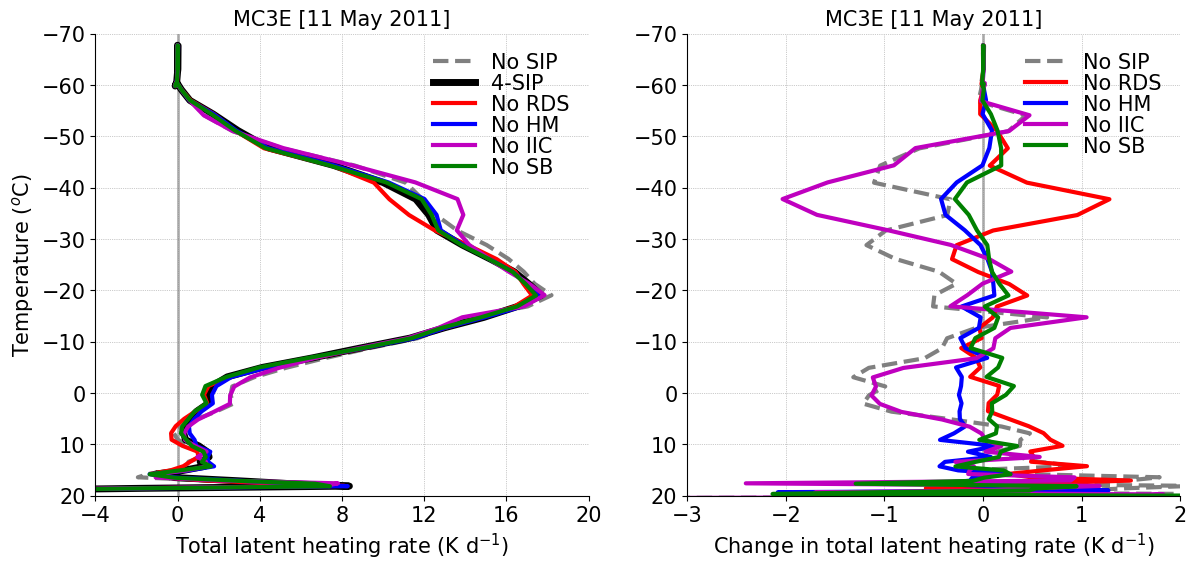

In [21]:

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-4, 20)
plt.ylim(20, -70)
plt.xticks([-4, 0, 4, 8, 12, 16, 20], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('MC3E [11 May 2011]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-3, 2)
plt.ylim(20, -70)
plt.xticks([-3, -2, -1, 0, 1, 2], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('MC3E [11 May 2011]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


In [100]:
#print(nice_cip_perm3.shape)
#print(data_v2_new)
print(data_v2_new.shape)
filtered_data_v2 = data_v2[data_v2['time'].isin(data_cip['time'])]
print(filtered_data_v2.shape)
print(data_v2.time)
print(data_cip.time)

(13267, 67)
(13267, 45)
0        56772
1        56773
2        56774
3        56775
4        56776
         ...  
13262    70071
13263    70072
13264    70073
13265    70074
13266    70075
Name: time, Length: 13267, dtype: int64
0        56772
1        56773
2        56774
3        56775
4        56776
         ...  
13300    70072
13301    70073
13302    70074
13303    70075
13304    70076
Name: time, Length: 13305, dtype: int64


In [47]:


w_thres = 2.
###### Without SIP
# lwc gperm3
#filt_lwc_up_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up_perl.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st_perl.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st_perl.mean(dim=('time','ncells'))

# inc gperm3
#filt_inc_up_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_dn_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_st_perl = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

#inc_up_nosip = filt_inc_up_perl.mean(dim=('time','ncells'))
#inc_dn_nosip = filt_inc_dn_perl.mean(dim=('time','ncells'))
#inc_st_nosip = filt_inc_st_perl.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_dn_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_st_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up_perl.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st_perl.mean(dim=('time','ncells'))

tempc_sip = ds_4sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_st_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st_perl.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_dn_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_st_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up_perl.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn_perl.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st_perl.mean(dim=('time','ncells'))


In [14]:


####================== Boxplot of ICON-LWC
#w_thres = 2.
#thres_q = 1.e-6
####### Without SIP
## lwc gperm3
#lwc_nosip_up_gperm3 = xr.where((ds_nosip_new.qc > thres_q) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#lwc_nosip_dn_gperm3 = xr.where((ds_nosip_new.qc > thres_q) & (ds_nosip_new.w_vel > -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#lwc_nosip_st_gperm3 = xr.where((ds_nosip_new.qc > thres_q) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#tempc_nosip = ds_nosip_new.tempc

#lwc_nosip_up_gperm3 = lwc_nosip_up_gperm3.values.flatten()
#lwc_nosip_dn_gperm3 = lwc_nosip_dn_gperm3.values.flatten()
#lwc_nosip_st_gperm3 = lwc_nosip_st_gperm3.values.flatten()
#tempc_nosip = tempc_nosip.values.flatten()

#df_lwc_nosip = pd.DataFrame({
#    'lwc_up': lwc_nosip_up_gperm3,
#    'lwc_dn': lwc_nosip_dn_gperm3,
#    'lwc_st': lwc_nosip_st_gperm3,
#    'tempc': tempc_nosip,
#})

#tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
#tempc_bin = np.sort(tempc_bin)

#df_lwc_nosip['temp_bin'] = np.digitize(df_lwc_nosip['tempc'], bins=tempc_bin, right=False)

#bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
#df_lwc_nosip['temp_bin'] = bin_edges[df_lwc_nosip['temp_bin']]

#df_lwc_up_nosip = df_lwc_nosip[['lwc_up', 'temp_bin']].dropna()
#df_lwc_dn_nosip = df_lwc_nosip[['lwc_dn', 'temp_bin']].dropna()
#df_lwc_st_nosip = df_lwc_nosip[['lwc_st', 'temp_bin']].dropna()

#df_lwc_up_nosip = df_lwc_up_nosip.dropna(subset=['temp_bin'])
#df_lwc_dn_nosip = df_lwc_dn_nosip.dropna(subset=['temp_bin'])
#df_lwc_st_nosip = df_lwc_st_nosip.dropna(subset=['temp_bin'])

#lwc_nosip_up_by_bin = [df_lwc_up_nosip[df_lwc_up_nosip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
#lwc_nosip_dn_by_bin = [df_lwc_dn_nosip[df_lwc_dn_nosip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
#lwc_nosip_st_by_bin = [df_lwc_st_nosip[df_lwc_st_nosip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [60]:

####================== Boxplot of ICON-LWC [4-SIP]
w_thres = 2.
thres_q = 1.e-12
###### Without SIP
# lwc gperm3
lwc_sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_dn_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_st_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

lwc_sip_up_gperm3 = lwc_sip_up_gperm3.values.flatten()
lwc_sip_dn_gperm3 = lwc_sip_dn_gperm3.values.flatten()
lwc_sip_st_gperm3 = lwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_lwc_sip = pd.DataFrame({
    'lwc_up': lwc_sip_up_gperm3,
    'lwc_dn': lwc_sip_dn_gperm3,
    'lwc_st': lwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_lwc_sip['temp_bin'] = np.digitize(df_lwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_lwc_sip['temp_bin'] = bin_edges[df_lwc_sip['temp_bin']]

df_lwc_up_sip = df_lwc_sip[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_sip = df_lwc_sip[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_sip = df_lwc_sip[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_sip = df_lwc_up_sip.dropna(subset=['temp_bin'])
df_lwc_dn_sip = df_lwc_dn_sip.dropna(subset=['temp_bin'])
df_lwc_st_sip = df_lwc_st_sip.dropna(subset=['temp_bin'])

lwc_sip_up_by_bin = [df_lwc_up_sip[df_lwc_up_sip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_sip_dn_by_bin = [df_lwc_dn_sip[df_lwc_dn_sip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_sip_st_by_bin = [df_lwc_st_sip[df_lwc_st_sip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [49]:

####================== Boxplot of ICON-LWC [3-SIP]
w_thres = 2.
thres_q = 1.e-2
###### Without SIP
# lwc gperm3
cdnc_sip_up_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_dn_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_st_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)
tempc_sip = ds_4sip_new.tempc

cdnc_sip_up_percm3 = cdnc_sip_up_percm3.values.flatten()
cdnc_sip_dn_percm3 = cdnc_sip_dn_percm3.values.flatten()
cdnc_sip_st_percm3 = cdnc_sip_st_percm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_cdnc_sip = pd.DataFrame({
    'cdnc_up': cdnc_sip_up_percm3,
    'cdnc_dn': cdnc_sip_dn_percm3,
    'cdnc_st': cdnc_sip_st_percm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_cdnc_sip['temp_bin'] = np.digitize(df_cdnc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_cdnc_sip['temp_bin'] = bin_edges[df_cdnc_sip['temp_bin']]

df_cdnc_up_sip = df_cdnc_sip[['cdnc_up', 'temp_bin']].dropna()
df_cdnc_dn_sip = df_cdnc_sip[['cdnc_dn', 'temp_bin']].dropna()
df_cdnc_st_sip = df_cdnc_sip[['cdnc_st', 'temp_bin']].dropna()

df_cdnc_up_sip = df_cdnc_up_sip.dropna(subset=['temp_bin'])
df_cdnc_dn_sip = df_cdnc_dn_sip.dropna(subset=['temp_bin'])
df_cdnc_st_sip = df_cdnc_st_sip.dropna(subset=['temp_bin'])

cdnc_sip_up_by_bin = [df_cdnc_up_sip[df_cdnc_up_sip['temp_bin'] == temp]['cdnc_up'].values for temp in bin_edges]
cdnc_sip_dn_by_bin = [df_cdnc_dn_sip[df_cdnc_dn_sip['temp_bin'] == temp]['cdnc_dn'].values for temp in bin_edges]
cdnc_sip_st_by_bin = [df_cdnc_st_sip[df_cdnc_st_sip['temp_bin'] == temp]['cdnc_st'].values for temp in bin_edges]


In [50]:

####================== Boxplot of ICON-IWC [3-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
iwc_sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_dn_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_st_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

iwc_sip_up_gperm3 = iwc_sip_up_gperm3.values.flatten()
iwc_sip_dn_gperm3 = iwc_sip_dn_gperm3.values.flatten()
iwc_sip_st_gperm3 = iwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_iwc_sip = pd.DataFrame({
    'iwc_up': iwc_sip_up_gperm3,
    'iwc_dn': iwc_sip_dn_gperm3,
    'iwc_st': iwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_iwc_sip['temp_bin'] = np.digitize(df_iwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_iwc_sip['temp_bin'] = bin_edges[df_iwc_sip['temp_bin']]

df_iwc_up_sip = df_iwc_sip[['iwc_up', 'temp_bin']].dropna()
df_iwc_dn_sip = df_iwc_sip[['iwc_dn', 'temp_bin']].dropna()
df_iwc_st_sip = df_iwc_sip[['iwc_st', 'temp_bin']].dropna()

df_iwc_up_sip = df_iwc_up_sip.dropna(subset=['temp_bin'])
df_iwc_dn_sip = df_iwc_dn_sip.dropna(subset=['temp_bin'])
df_iwc_st_sip = df_iwc_st_sip.dropna(subset=['temp_bin'])

iwc_sip_up_by_bin = [df_iwc_up_sip[df_iwc_up_sip['temp_bin'] == temp]['iwc_up'].values for temp in bin_edges]
iwc_sip_dn_by_bin = [df_iwc_dn_sip[df_iwc_dn_sip['temp_bin'] == temp]['iwc_dn'].values for temp in bin_edges]
iwc_sip_st_by_bin = [df_iwc_st_sip[df_iwc_st_sip['temp_bin'] == temp]['iwc_st'].values for temp in bin_edges]


In [51]:

####================== Boxplot of ICON-INC [3-SIP]
w_thres = 2.
thres_q = 1.e-4
###### Without SIP
# lwc gperm3
inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_dn_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_st_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_sip = ds_4sip_new.tempc

inc_sip_up_perl = inc_sip_up_perl.values.flatten()
inc_sip_dn_perl = inc_sip_dn_perl.values.flatten()
inc_sip_st_perl = inc_sip_st_perl.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_inc_sip = pd.DataFrame({
    'inc_up': inc_sip_up_perl,
    'inc_dn': inc_sip_dn_perl,
    'inc_st': inc_sip_st_perl,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_sip['temp_bin'] = np.digitize(df_inc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_sip['temp_bin'] = bin_edges[df_inc_sip['temp_bin']]

df_inc_up_sip = df_inc_sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_sip = df_inc_sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_sip = df_inc_sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_sip = df_inc_up_sip.dropna(subset=['temp_bin'])
df_inc_dn_sip = df_inc_dn_sip.dropna(subset=['temp_bin'])
df_inc_st_sip = df_inc_st_sip.dropna(subset=['temp_bin'])

inc_sip_up_by_bin = [df_inc_up_sip[df_inc_up_sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_sip_dn_by_bin = [df_inc_dn_sip[df_inc_dn_sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_sip_st_by_bin = [df_inc_st_sip[df_inc_st_sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


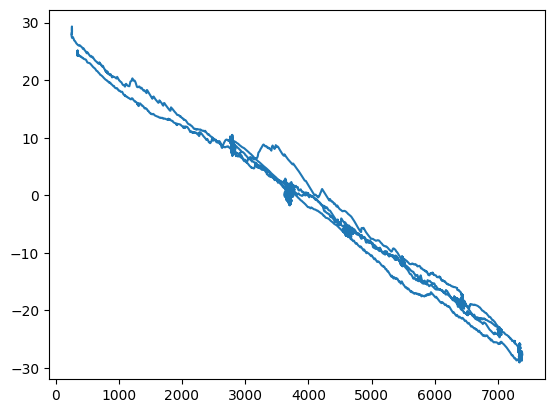

In [5]:

import matplotlib.pyplot as plt

plt.plot(data_v2['pres_alt'], data_v2['air_temp'])

In [3]:
import pandas as pd
import numpy as np


# CIP
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/20110511_154612.CIP.1Hz'
data_cip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=40)

data_cip.columns = ['time','Nt_perm3','iwc_gperm3']+ ['Nt_perm4'] * (data_cip.shape[1] - 3)

# HVPS
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/20110511_154612.HVPS3.1Hz'
data_hvps = pd.read_csv(file_path, sep='\s+', header=None, skiprows=40)

data_hvps.columns = ['time','Nt_perm3','iwc_gperm3']+ ['Nt_perm4'] * (data_hvps.shape[1] - 3)

# Flight data
file_path = '/work/bb1163/b382718/output/mc3e/observations/aircraft_optical_probe_data/GHRC_DATA/2011_05_11_15_46_09_v2.mc3e'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=63)

data_v2.columns = ['time', 'air_temp', 'machno', 'ias', 'tas', 
                   'pres_alt', 'pot_temp', 'pitot_wing', 'cabin_pres', 'static_pr',
                   'dewpt', 'mix_ratio', 'dew_point', 'frost_point', 'pos_roll', 
                   'pos_pitch', 'pos_head', 'posz_acc', 'pos_lat', 'pos_lon',
                   'pos_alt', 'pos_spd', 'pos_trk', 'alpha', 'beta', 
                   'wind_z', 'vert_vel', 'wind_m', 'wind_d', 'turb',
                   'lwc_king', 'twc_nev', 'lwc_nev', 'conc_cdp', 'lwc_cdp', 
                   'cdp_meanD', 'cdp_volD', 'cdp_effrad', 'conc_2dc', '2dc_meanD',
                   '2dc_volD', '2dc_effrad', 'icemsofreq', 'cpc_conc', 'tsg_gate']

data_v2['time'] = data_v2['time'].astype(int)
# sum cip concentration over all diameter bins

diam_cip_end_bin  = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 
                     475.0, 550.0, 625.0, 700.0, 800.0, 900.0, 1000.0, 1200.0,
                     1400.0, 1600.0, 1800.0, 2000.0];

diam_hvps_end_bin = [200.0, 400.0, 600.0, 800.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0,
                    2200.0, 2600.0, 3000.0, 3400.0, 3800.0, 4200.0, 4600.0, 5000.0, 6000.0,  
                    7000.0, 8000.0, 9000.0, 10000.0, 12000.0, 14000.0, 16000.0, 18000.0,
                    20000.0, 25000.0, 30000.0]

diam_cip_width = np.diff(diam_cip_end_bin)*1.e-6 # µm to m
diam_hvps_width = np.diff(diam_hvps_end_bin)*1.e-6 # µm to m

print(diam_cip_width.shape, diam_hvps_width.shape)

## TINC
nt_cip_perm4 = data_cip.iloc[:, 3:].values
nt_hvps_perm4 = data_hvps.iloc[:, 3:].values

cip_mask = (nt_cip_perm4 != 9.99e+30) & (nt_cip_perm4 != 0.0)
hvps_mask = (nt_hvps_perm4 != 9.99e+30) & (nt_hvps_perm4 != 0.0)
#nice_perm3 = np.where(cip_mask & (diam_cip_end_bin[:-1] > 2.e-4), nt_perm4 * diam_cip_width, 0)

nice_cip_perm3 = np.where(cip_mask, nt_cip_perm4 * diam_cip_width, np.nan)  # basically considering all particles from 50 to 2000 µm
nice_hvps_perm3 = np.where(hvps_mask, nt_hvps_perm4 * diam_hvps_width, np.nan)  # basically considering all particles from 200 to 30000 µm

nice_cip_perm3 = np.nansum(nice_cip_perm3, axis=1)
nice_hvps_perm3 = np.nansum(nice_hvps_perm3, axis=1)
#valid_rows = np.any(cip_mask, axis=1)
#valid_times = data_cip.loc[valid_rows, 'time']
#print(valid_times.values)
##non_zero_values = nice_perm3[nice_perm3 != 0.]
#non_nan_values = nice_perm3[~np.isnan(nice_perm3)]
#print(non_nan_values)

# IWC
iwc_cip_gperm3 = data_cip.iwc_gperm3
iwc_hvps_gperm3 = data_hvps.iwc_gperm3

cip_mask = (iwc_cip_gperm3 != 9.99e+30) & (iwc_cip_gperm3 != 0.0)
hvps_mask = (iwc_hvps_gperm3 != 9.99e+30) & (iwc_hvps_gperm3 != 0.0)

iwc_cip_gperm3 = np.where(cip_mask, iwc_cip_gperm3, np.nan)  
iwc_hvps_gperm3 = np.where(hvps_mask, iwc_hvps_gperm3, np.nan)  



data_cip['nice_cip_perm3'] = nice_cip_perm3
data_cip['nice_cip_perl'] = 1.e-3*nice_cip_perm3

data_hvps['nice_hvps_perm3'] = nice_hvps_perm3
data_hvps['nice_hvps_perl'] = 1.e-3*nice_hvps_perm3

data_cip['iwc_cip_gperm3'] = iwc_cip_gperm3
data_hvps['iwc_hvps_gperm3'] = iwc_hvps_gperm3


data_cip_new = data_cip.drop(columns=['Nt_perm4'])  # no need of 19 (conc in each bin) columns, drop it
data_hvps_new = data_hvps.drop(columns=['Nt_perm4'])  # no need of 19 (conc in each bin) columns, drop it 

data_cip_new = data_cip.drop(columns=['iwc_gperm3'])  
data_hvps_new = data_hvps.drop(columns=['iwc_gperm3'])

ds_v2_cip_comb = pd.merge(data_v2, data_cip_new, on='time', how='inner')
ds_v2_hvps_comb = pd.merge(data_v2, data_hvps_new, on='time', how='inner')

# TINC
ds_v2_cip_comb['nice_cip_up_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (ds_v2_cip_comb.vert_vel > 2.), ds_v2_cip_comb.nice_cip_perl, np.nan)
ds_v2_cip_comb['nice_cip_dn_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (ds_v2_cip_comb.vert_vel < -2.), ds_v2_cip_comb.nice_cip_perl, np.nan)
ds_v2_cip_comb['nice_cip_st_perl'] = np.where((ds_v2_cip_comb.nice_cip_perl > 0.) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), ds_v2_cip_comb.nice_cip_perl, np.nan)

ds_v2_hvps_comb['nice_hvps_up_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (ds_v2_hvps_comb.vert_vel > 2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)
ds_v2_hvps_comb['nice_hvps_dn_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (ds_v2_hvps_comb.vert_vel < -2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)
ds_v2_hvps_comb['nice_hvps_st_perl'] = np.where((ds_v2_hvps_comb.nice_hvps_perl > 0.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), ds_v2_hvps_comb.nice_hvps_perl, np.nan)

# IWC
ds_v2_cip_comb['iwc_cip_up_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (ds_v2_cip_comb.vert_vel > 2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)
ds_v2_cip_comb['iwc_cip_dn_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (ds_v2_cip_comb.vert_vel < -2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)
ds_v2_cip_comb['iwc_cip_st_gperm3'] = np.where((ds_v2_cip_comb.iwc_cip_gperm3 > 0.) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), 
                                               ds_v2_cip_comb.iwc_cip_gperm3, np.nan)

ds_v2_hvps_comb['iwc_hvps_up_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (ds_v2_hvps_comb.vert_vel > 2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)
ds_v2_hvps_comb['iwc_hvps_dn_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (ds_v2_hvps_comb.vert_vel < -2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)
ds_v2_hvps_comb['iwc_hvps_st_gperm3'] = np.where((ds_v2_hvps_comb.iwc_hvps_gperm3 > 0.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), 
                                               ds_v2_hvps_comb.iwc_hvps_gperm3, np.nan)

# CDNC
ds_v2_hvps_comb['cdnc_cdp_up_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (ds_v2_hvps_comb.vert_vel > 2.), ds_v2_hvps_comb.conc_cdp, np.nan)
ds_v2_hvps_comb['cdnc_cdp_dn_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (ds_v2_hvps_comb.vert_vel < -2.), ds_v2_hvps_comb.conc_cdp, np.nan)
ds_v2_hvps_comb['cdnc_cdp_st_percm3'] = np.where((ds_v2_hvps_comb.conc_cdp > 5.) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.), ds_v2_hvps_comb.conc_cdp, np.nan)

# LWC
ds_v2_hvps_comb['lwc_cdp_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)
ds_v2_hvps_comb['lwc_cdp_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)
ds_v2_hvps_comb['lwc_cdp_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_cdp > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_cdp, np.nan)

ds_v2_hvps_comb['lwc_king_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)
ds_v2_hvps_comb['lwc_king_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)
ds_v2_hvps_comb['lwc_king_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_king > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_king, np.nan)

ds_v2_hvps_comb['lwc_nev_up_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (ds_v2_hvps_comb.vert_vel > 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)
ds_v2_hvps_comb['lwc_nev_dn_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (ds_v2_hvps_comb.vert_vel < -2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)
ds_v2_hvps_comb['lwc_nev_st_gperm3'] = np.where((ds_v2_hvps_comb.lwc_nev > 1.e-6) & (np.abs(ds_v2_hvps_comb.vert_vel) < 2.) & (ds_v2_hvps_comb.conc_cdp > 5.), 
                                                ds_v2_hvps_comb.lwc_nev, np.nan)


# make a plot using seaborn
#temp_bin = np.array([0., -4., -8., -12., -16., -20., -24., -28., -32.])
#temp_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_bin = np.arange(-30, 20, 5)
temp_bin = np.sort(temp_bin)

temp_cdp_bin = np.arange(-30, 20, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)


ds_v2_cip_comb['temp_bin'] = pd.cut(ds_v2_cip_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2_hvps_comb['temp_bin'] = pd.cut(ds_v2_hvps_comb['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)

# Merge temperature bins into CIP dataset
ds_v2_cip_comb = ds_v2_cip_comb.copy()
#data_cip_new['temp_bin'] = data_v2_new['temp_bin'].values

# Remove NaN values (cases where no temperature bin was assigned)
ds_v2_cip_comb = ds_v2_cip_comb.dropna(subset=['temp_bin'])
ds_v2_hvps_comb = ds_v2_hvps_comb.dropna(subset=['temp_bin'])

# Convert bin labels to numeric for proper sorting
ds_v2_cip_comb['temp_bin'] = ds_v2_cip_comb['temp_bin'].astype(float)
ds_v2_hvps_comb['temp_bin'] = ds_v2_hvps_comb['temp_bin'].astype(float)


(19,) (28,)


/tmp/ipykernel_2715970/2155219734.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
/tmp/ipykernel_2715970/2155219734.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
/tmp/ipykernel_2715970/2155219734.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)


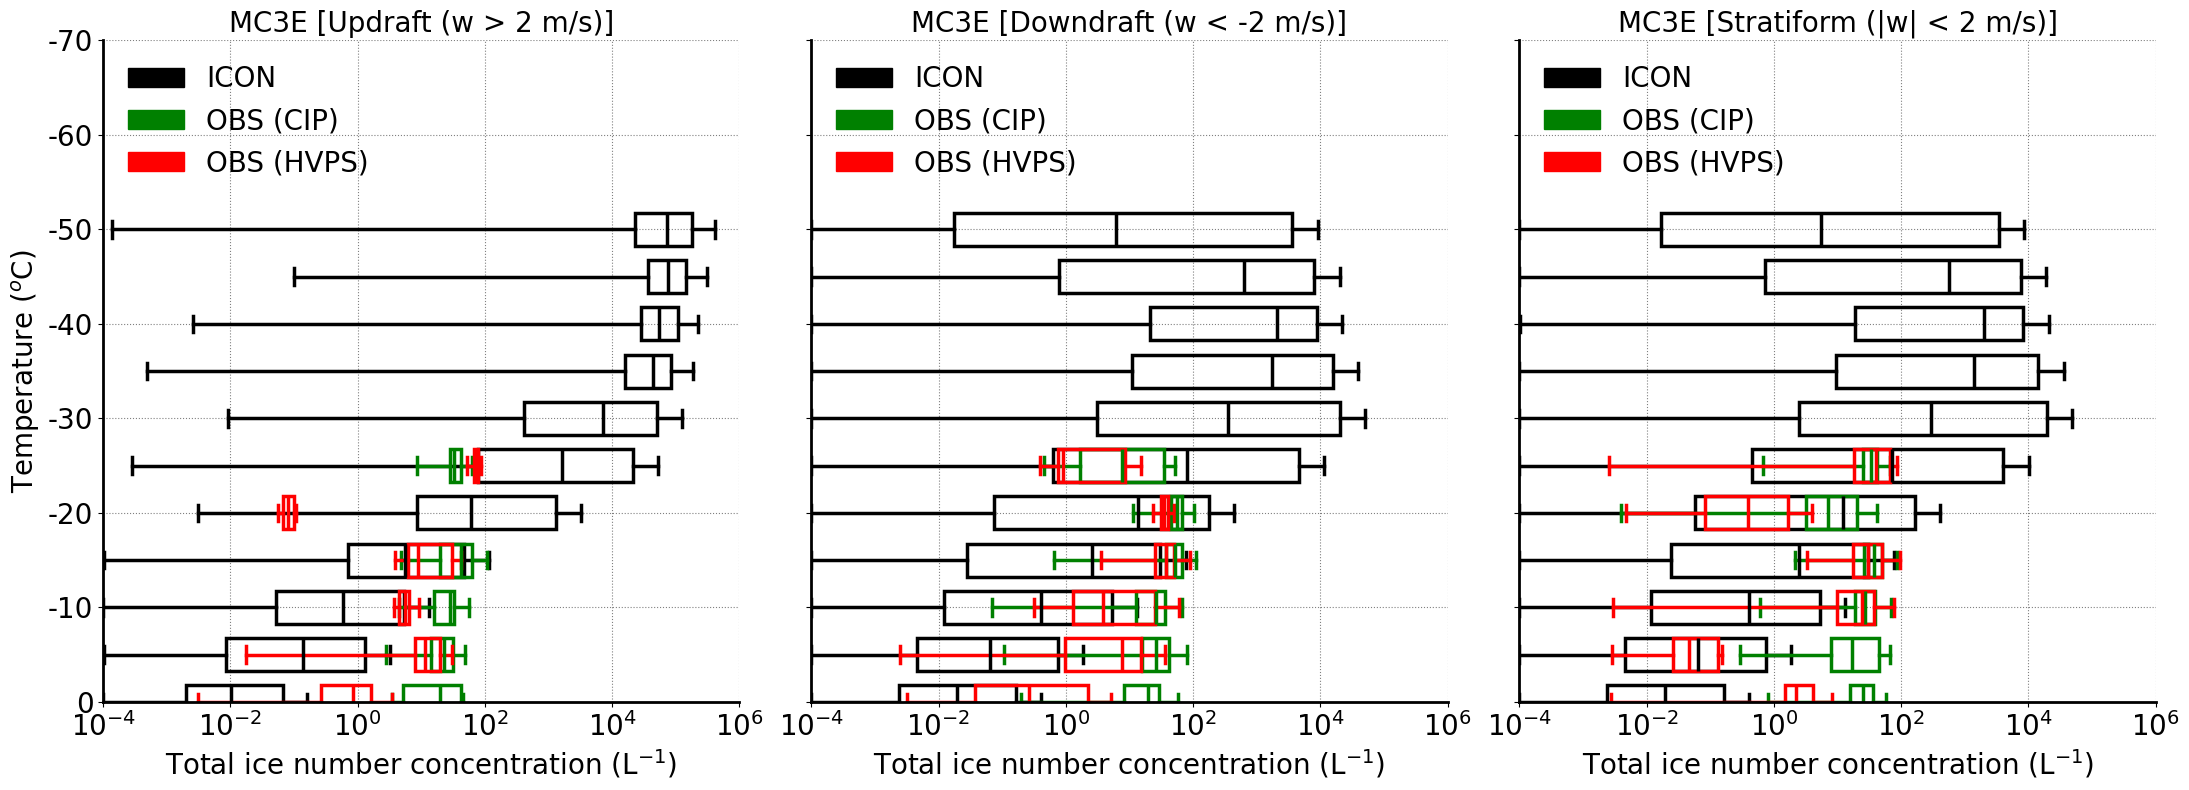

In [57]:

# CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)
df_v2_cip_comb['tempc'] = df_v2_cip_comb['air_temp']

#temp_cip_bin = np.arange(df_v2_cip_comb['tempc'].min() - 2, df_v2_cip_comb['tempc'].max() + 2, 3)  

temp_cip_bin = np.arange(-30, 20, 5)

#temp_cip_bin = np.arange(-30, 3, 4)

temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_cip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_cip_bin']]

# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

#temp_hvps_bin = np.arange(-30, 3, 4)
temp_hvps_bin = np.arange(-30, 20, 5)
temp_hvps_bin = np.sort(temp_hvps_bin)
df_v2_hvps_comb['temp_hvps_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_hvps_bin, right=False)

bin_edges = np.concatenate([temp_hvps_bin - 2, [temp_hvps_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_hvps_bin']]


### TINC
# CIP
df_nice_up_cip = df_v2_cip_comb[['nice_cip_up_perl', 'temp_bin']].dropna()
df_nice_dn_cip = df_v2_cip_comb[['nice_cip_dn_perl', 'temp_bin']].dropna()
df_nice_st_cip = df_v2_cip_comb[['nice_cip_st_perl', 'temp_bin']].dropna()

df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
df_nice_dn_cip = df_nice_dn_cip.dropna(subset=['temp_bin'])
df_nice_st_cip = df_nice_st_cip.dropna(subset=['temp_bin'])

nice_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['nice_cip_up_perl'].values for temp in bin_edges]
nice_cip_dn_by_bin = [df_nice_dn_cip[df_nice_dn_cip['temp_bin'] == temp]['nice_cip_dn_perl'].values for temp in bin_edges]
nice_cip_st_by_bin = [df_nice_st_cip[df_nice_st_cip['temp_bin'] == temp]['nice_cip_st_perl'].values for temp in bin_edges]

# HVPS
df_nice_up_hvps = df_v2_hvps_comb[['nice_hvps_up_perl', 'temp_bin']].dropna()
df_nice_dn_hvps = df_v2_hvps_comb[['nice_hvps_dn_perl', 'temp_bin']].dropna()
df_nice_st_hvps = df_v2_hvps_comb[['nice_hvps_st_perl', 'temp_bin']].dropna()

df_nice_up_hvps = df_nice_up_hvps.dropna(subset=['temp_bin'])
df_nice_dn_hvps = df_nice_dn_hvps.dropna(subset=['temp_bin'])
df_nice_st_hvps = df_nice_st_hvps.dropna(subset=['temp_bin'])

nice_hvps_up_by_bin = [df_nice_up_hvps[df_nice_up_hvps['temp_bin'] == temp]['nice_hvps_up_perl'].values for temp in bin_edges]
nice_hvps_dn_by_bin = [df_nice_dn_hvps[df_nice_dn_hvps['temp_bin'] == temp]['nice_hvps_dn_perl'].values for temp in bin_edges]
nice_hvps_st_by_bin = [df_nice_st_hvps[df_nice_st_hvps['temp_bin'] == temp]['nice_hvps_st_perl'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']
#data_list = [nice_up_by_bin, nice_dn_by_bin, nice_st_by_bin]
#temp_bins_list = [temp_cip_bin, temp_cip_bin, temp_cip_bin]

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(nice_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(nice_hvps_up_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(inc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(nice_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(nice_hvps_dn_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(inc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(nice_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(nice_hvps_st_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e6)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
    ax.set_ylim(0, -70)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_icon_patch = mpatches.Patch(color='black', label='ICON')
    obs_cip_patch = mpatches.Patch(color='green', label='OBS (CIP)')
    obs_hvps_patch = mpatches.Patch(color='red', label='OBS (HVPS)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2715970/493484667.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
/tmp/ipykernel_2715970/493484667.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
/tmp/ipykernel_2715970/493484667.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)


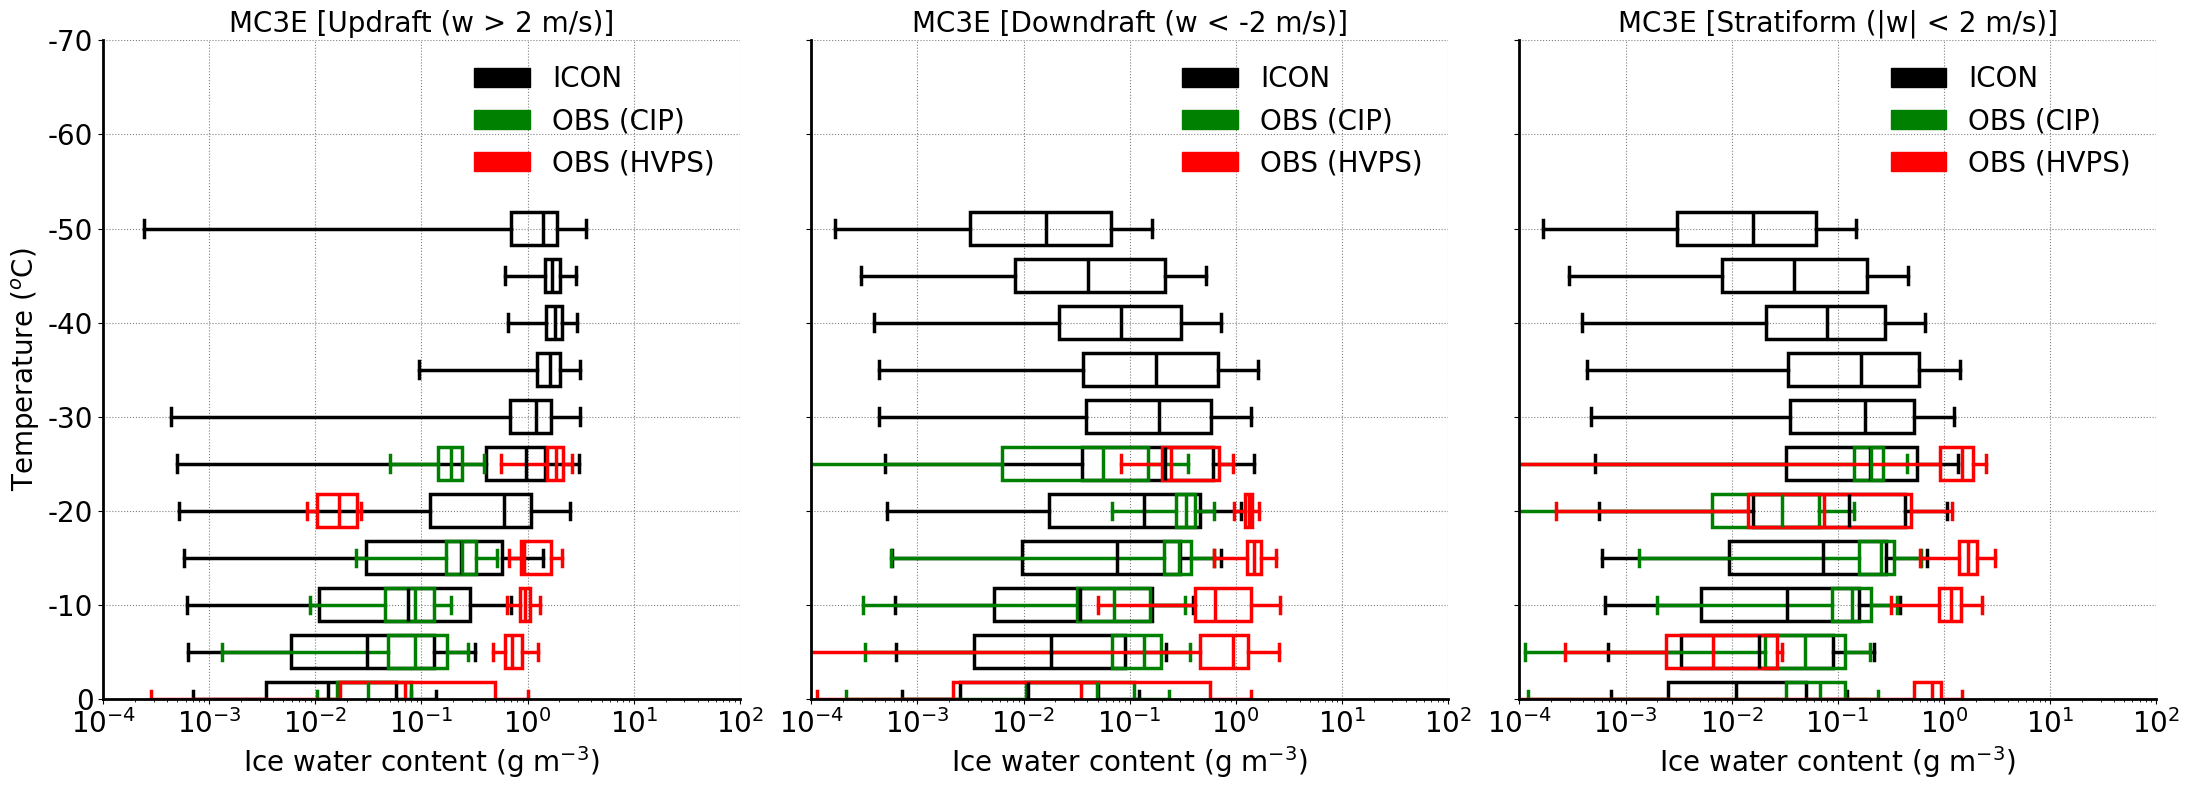

In [56]:

## IWC
# CIP
df_iwc_up_cip = df_v2_cip_comb[['iwc_cip_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_cip = df_v2_cip_comb[['iwc_cip_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_cip = df_v2_cip_comb[['iwc_cip_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_cip = df_iwc_up_cip.dropna(subset=['temp_bin'])
df_iwc_dn_cip = df_iwc_dn_cip.dropna(subset=['temp_bin'])
df_iwc_st_cip = df_iwc_st_cip.dropna(subset=['temp_bin'])

iwc_cip_up_by_bin = [df_iwc_up_cip[df_iwc_up_cip['temp_bin'] == temp]['iwc_cip_up_gperm3'].values for temp in bin_edges]
iwc_cip_dn_by_bin = [df_iwc_dn_cip[df_iwc_dn_cip['temp_bin'] == temp]['iwc_cip_dn_gperm3'].values for temp in bin_edges]
iwc_cip_st_by_bin = [df_iwc_st_cip[df_iwc_st_cip['temp_bin'] == temp]['iwc_cip_st_gperm3'].values for temp in bin_edges]

# HVPS
df_iwc_up_hvps = df_v2_hvps_comb[['iwc_hvps_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_hvps = df_v2_hvps_comb[['iwc_hvps_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_hvps = df_v2_hvps_comb[['iwc_hvps_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_hvps = df_iwc_up_hvps.dropna(subset=['temp_bin'])
df_iwc_dn_hvps = df_iwc_dn_hvps.dropna(subset=['temp_bin'])
df_iwc_st_hvps = df_iwc_st_hvps.dropna(subset=['temp_bin'])

iwc_hvps_up_by_bin = [df_iwc_up_hvps[df_iwc_up_hvps['temp_bin'] == temp]['iwc_hvps_up_gperm3'].values for temp in bin_edges]
iwc_hvps_dn_by_bin = [df_iwc_dn_hvps[df_iwc_dn_hvps['temp_bin'] == temp]['iwc_hvps_dn_gperm3'].values for temp in bin_edges]
iwc_hvps_st_by_bin = [df_iwc_st_hvps[df_iwc_st_hvps['temp_bin'] == temp]['iwc_hvps_st_gperm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']
#data_list = [nice_up_by_bin, nice_dn_by_bin, nice_st_by_bin]
#temp_bins_list = [temp_cip_bin, temp_cip_bin, temp_cip_bin]

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha=1;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(tiwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(iwc_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(iwc_hvps_up_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(tiwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        ax.boxplot(iwc_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(iwc_hvps_dn_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(tiwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        ax.boxplot(iwc_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(iwc_hvps_st_by_bin[:-1], positions=temp_hvps_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e2)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
    ax.set_ylim(0, -70)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_icon_patch = mpatches.Patch(color='black', label='ICON')
    obs_cip_patch = mpatches.Patch(color='green', label='OBS (CIP)')
    obs_hvps_patch = mpatches.Patch(color='red', label='OBS (HVPS)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_icon_patch, obs_cip_patch, obs_hvps_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2715970/3462090509.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_2715970/3462090509.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_2715970/3462090509.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)


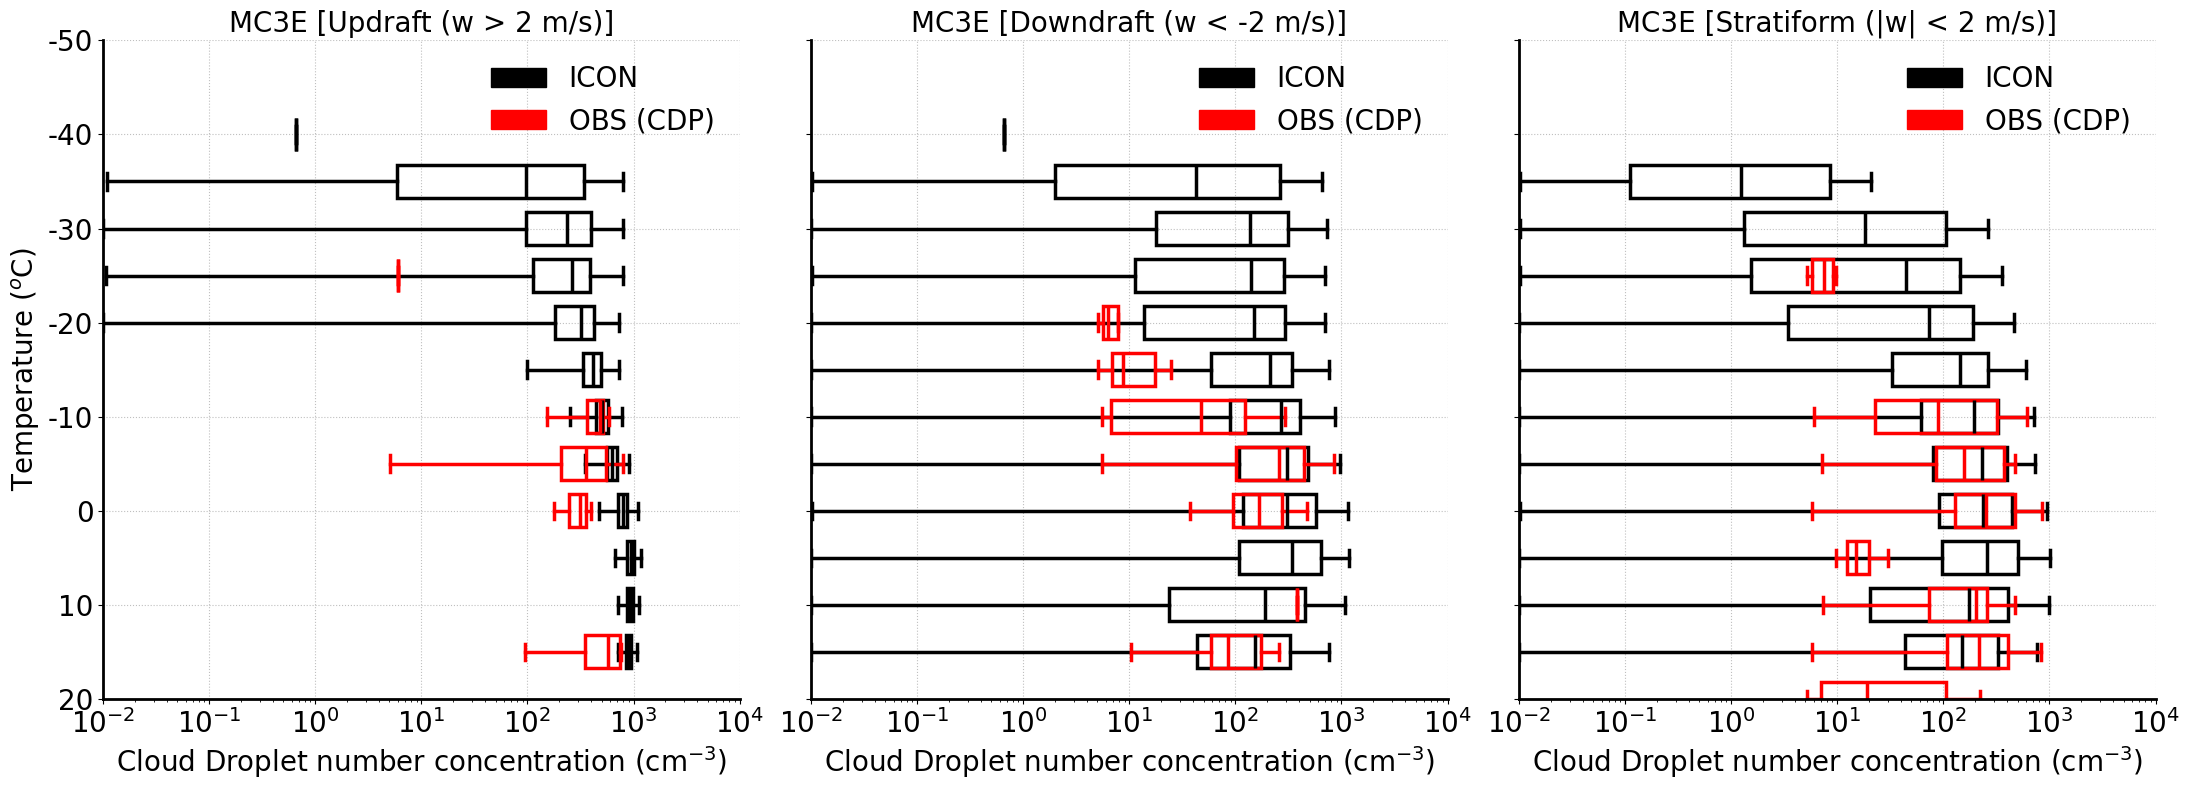

In [58]:

# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)
df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]

# CDNC
df_cdnc_up_cdp = df_v2_hvps_comb[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_dn_cdp = df_v2_hvps_comb[['cdnc_cdp_dn_percm3', 'temp_bin']].dropna()
df_cdnc_st_cdp = df_v2_hvps_comb[['cdnc_cdp_st_percm3', 'temp_bin']].dropna()

df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
df_cdnc_dn_cdp = df_cdnc_dn_cdp.dropna(subset=['temp_bin'])
df_cdnc_st_cdp = df_cdnc_st_cdp.dropna(subset=['temp_bin'])

cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]
cdnc_cdp_dn_by_bin = [df_cdnc_dn_cdp[df_cdnc_dn_cdp['temp_bin'] == temp]['cdnc_cdp_dn_percm3'].values for temp in bin_edges]
cdnc_cdp_st_by_bin = [df_cdnc_st_cdp[df_cdnc_st_cdp['temp_bin'] == temp]['cdnc_cdp_st_percm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        ax.boxplot(cdnc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud Droplet number concentration (cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=0.5)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2715970/1136517385.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_2715970/1136517385.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_2715970/1136517385.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)


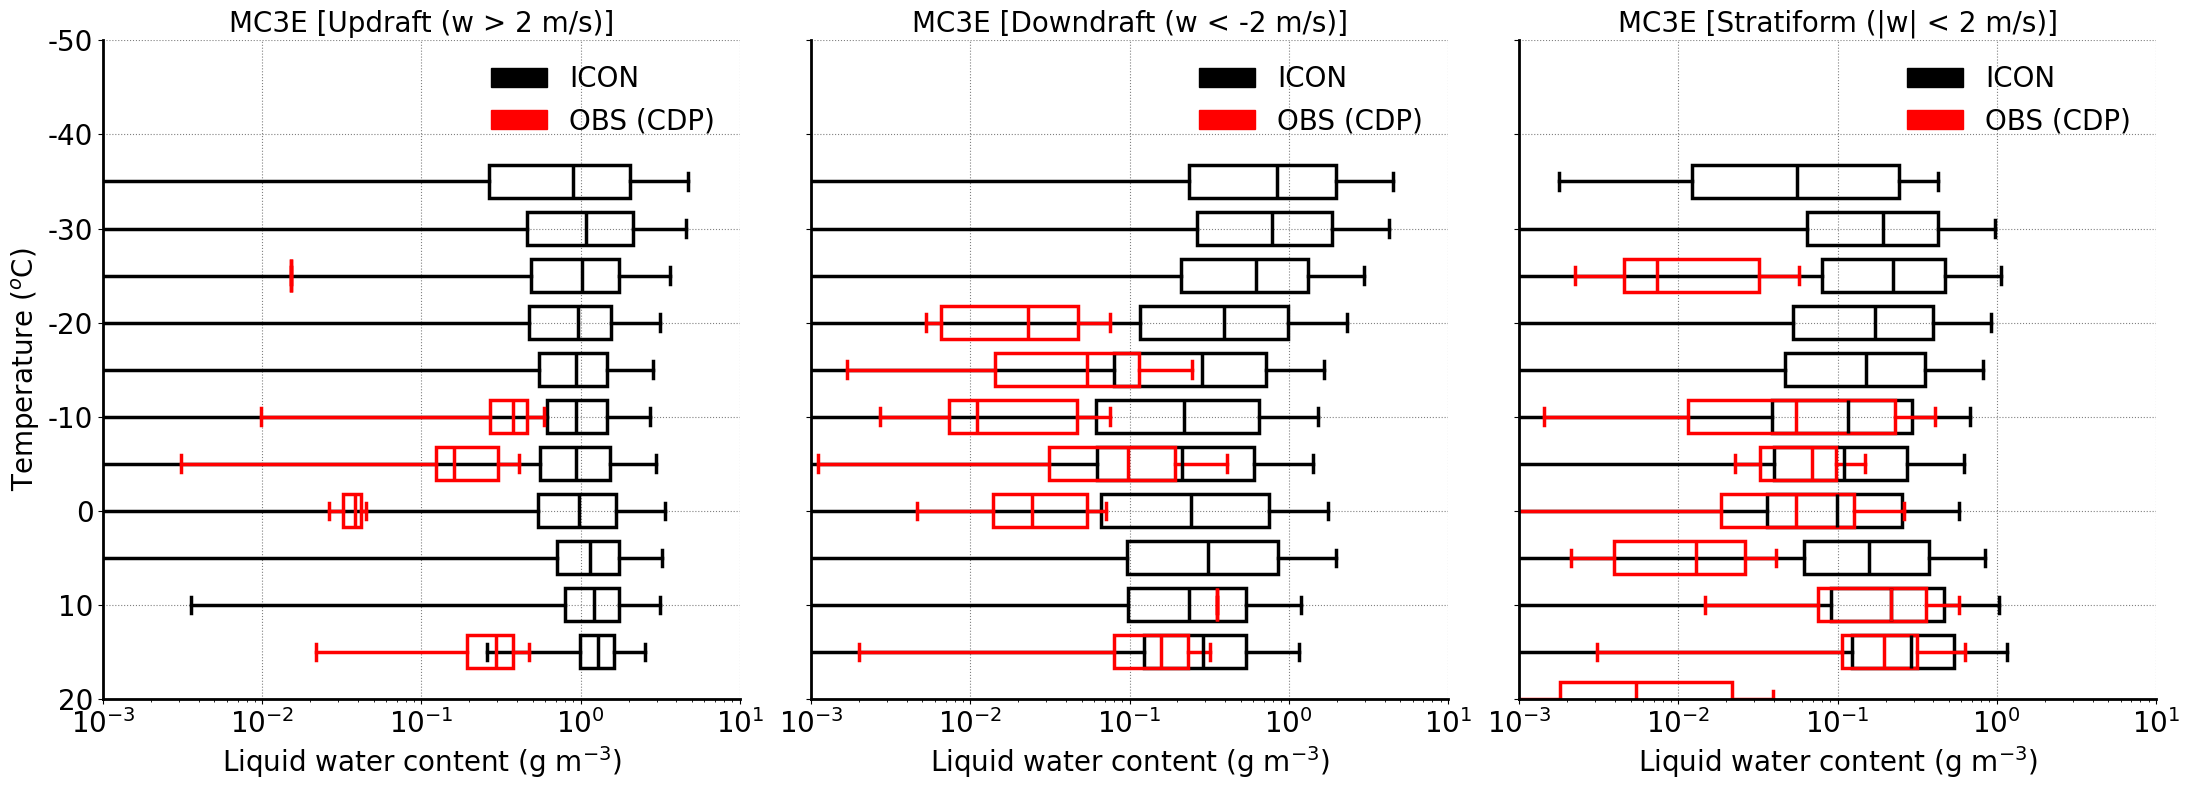

In [62]:


# HVPS
df_v2_hvps_comb = pd.DataFrame(ds_v2_hvps_comb)
df_v2_hvps_comb['tempc'] = df_v2_hvps_comb['air_temp']

temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)
df_v2_hvps_comb['temp_cdp_bin'] = np.digitize(df_v2_hvps_comb['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2_hvps_comb['temp_bin'] = bin_edges[df_v2_hvps_comb['temp_cdp_bin']]

# LWC-CDP
df_lwc_up_cdp = df_v2_hvps_comb[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_cdp = df_v2_hvps_comb[['lwc_cdp_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_cdp = df_v2_hvps_comb[['lwc_cdp_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
df_lwc_dn_cdp = df_lwc_dn_cdp.dropna(subset=['temp_bin'])
df_lwc_st_cdp = df_lwc_st_cdp.dropna(subset=['temp_bin'])

lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]
lwc_cdp_dn_by_bin = [df_lwc_dn_cdp[df_lwc_dn_cdp['temp_bin'] == temp]['lwc_cdp_dn_gperm3'].values for temp in bin_edges]
lwc_cdp_st_by_bin = [df_lwc_st_cdp[df_lwc_st_cdp['temp_bin'] == temp]['lwc_cdp_st_gperm3'].values for temp in bin_edges]


# LWC-KING
df_lwc_up_king = df_v2_hvps_comb[['lwc_king_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_king = df_v2_hvps_comb[['lwc_king_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_king = df_v2_hvps_comb[['lwc_king_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_king = df_lwc_up_king.dropna(subset=['temp_bin'])
df_lwc_dn_king = df_lwc_dn_king.dropna(subset=['temp_bin'])
df_lwc_st_king = df_lwc_st_king.dropna(subset=['temp_bin'])

lwc_king_up_by_bin = [df_lwc_up_king[df_lwc_up_king['temp_bin'] == temp]['lwc_king_up_gperm3'].values for temp in bin_edges]
lwc_king_dn_by_bin = [df_lwc_dn_king[df_lwc_dn_king['temp_bin'] == temp]['lwc_king_dn_gperm3'].values for temp in bin_edges]
lwc_king_st_by_bin = [df_lwc_st_king[df_lwc_st_king['temp_bin'] == temp]['lwc_king_st_gperm3'].values for temp in bin_edges]

# LWC-NEVZOROV
df_lwc_up_nev = df_v2_hvps_comb[['lwc_nev_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_nev = df_v2_hvps_comb[['lwc_nev_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_nev = df_v2_hvps_comb[['lwc_nev_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_nev = df_lwc_up_nev.dropna(subset=['temp_bin'])
df_lwc_dn_nev = df_lwc_dn_nev.dropna(subset=['temp_bin'])
df_lwc_st_nev = df_lwc_st_nev.dropna(subset=['temp_bin'])

lwc_nev_up_by_bin = [df_lwc_up_nev[df_lwc_up_nev['temp_bin'] == temp]['lwc_nev_up_gperm3'].values for temp in bin_edges]
lwc_nev_dn_by_bin = [df_lwc_dn_nev[df_lwc_dn_nev['temp_bin'] == temp]['lwc_nev_dn_gperm3'].values for temp in bin_edges]
lwc_nev_st_by_bin = [df_lwc_st_nev[df_lwc_st_nev['temp_bin'] == temp]['lwc_nev_st_gperm3'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['MC3E [Updraft (w > 2 m/s)]', 'MC3E [Downdraft (w < -2 m/s)]', 'MC3E [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-3, 1.e1)
    ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(20, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [63]:
ds_4sip.time

<xarray.DataArray 'time' (time: 121)>
array(['2011-05-10T00:00:00.000000000', '2011-05-10T00:30:00.000000000',
       '2011-05-10T01:00:00.000000000', '2011-05-10T01:30:00.000000000',
       '2011-05-10T02:00:00.000000000', '2011-05-10T02:30:00.000000000',
       '2011-05-10T03:00:00.000000000', '2011-05-10T03:30:00.000000000',
       '2011-05-10T04:00:00.000000000', '2011-05-10T04:30:00.000000000',
       '2011-05-10T05:00:00.000000000', '2011-05-10T05:30:00.000000000',
       '2011-05-10T06:00:00.000000000', '2011-05-10T06:30:00.000000000',
       '2011-05-10T07:00:00.000000000', '2011-05-10T07:30:00.000000000',
       '2011-05-10T08:00:00.000000000', '2011-05-10T08:30:00.000000000',
       '2011-05-10T09:00:00.000000000', '2011-05-10T09:30:00.000000000',
       '2011-05-10T10:00:00.000000000', '2011-05-10T10:30:00.000000000',
       '2011-05-10T11:00:00.000000000', '2011-05-10T11:30:00.000000000',
       '2011-05-10T12:00:00.000000000', '2011-05-10T12:30:00.000000000',
       '2011-05-10T13:00:00.000000000', '2011-05-10T13:30:00.000000000',
       '2011-05-10T14:00:00.000000000', '2011-05-10T14:30:00.000000000',
       '2011-05-10T15:00:00.000000000', '2011-05-10T15:30:00.000000000',
       '2011-05-10T16:00:00.000000000', '2011-05-10T16:30:00.000000000',
       '2011-05-10T17:00:00.000000000', '2011-05-10T17:30:00.000000000',
       '2011-05-10T18:00:00.000000000', '2011-05-10T18:30:00.000000000',
       '2011-05-10T19:00:00.000000000', '2011-05-10T19:30:00.000000000',
       '2011-05-10T20:00:00.000000000', '2011-05-10T20:30:00.000000000',
       '2011-05-10T21:00:00.000000000', '2011-05-10T21:30:00.000000000',
       '2011-05-10T22:00:00.000000000', '2011-05-10T22:30:00.000000000',
       '2011-05-10T23:00:00.000000000', '2011-05-10T23:30:00.000000000',
       '2011-05-11T00:00:00.000000000', '2011-05-11T00:30:00.000000000',
       '2011-05-11T01:00:00.000000000', '2011-05-11T01:30:00.000000000',
       '2011-05-11T02:00:00.000000000', '2011-05-11T02:30:00.000000000',
       '2011-05-11T03:00:00.000000000', '2011-05-11T03:30:00.000000000',
       '2011-05-11T04:00:00.000000000', '2011-05-11T04:30:00.000000000',
       '2011-05-11T05:00:00.000000000', '2011-05-11T05:30:00.000000000',
       '2011-05-11T06:00:00.000000000', '2011-05-11T06:30:00.000000000',
       '2011-05-11T07:00:00.000000000', '2011-05-11T07:30:00.000000000',
       '2011-05-11T08:00:00.000000000', '2011-05-11T08:30:00.000000000',
       '2011-05-11T09:00:00.000000000', '2011-05-11T09:30:00.000000000',
       '2011-05-11T10:00:00.000000000', '2011-05-11T10:30:00.000000000',
       '2011-05-11T11:00:00.000000000', '2011-05-11T11:30:00.000000000',
       '2011-05-11T12:00:00.000000000', '2011-05-11T12:30:00.000000000',
       '2011-05-11T13:00:00.000000000', '2011-05-11T13:30:00.000000000',
       '2011-05-11T14:00:00.000000000', '2011-05-11T14:30:00.000000000',
       '2011-05-11T15:00:00.000000000', '2011-05-11T15:30:00.000000000',
       '2011-05-11T16:00:00.000000000', '2011-05-11T16:30:00.000000000',
       '2011-05-11T17:00:00.000000000', '2011-05-11T17:30:00.000000000',
       '2011-05-11T18:00:00.000000000', '2011-05-11T18:30:00.000000000',
       '2011-05-11T19:00:00.000000000', '2011-05-11T19:30:00.000000000',
       '2011-05-11T20:00:00.000000000', '2011-05-11T20:30:00.000000000',
       '2011-05-11T21:00:00.000000000', '2011-05-11T21:30:00.000000000',
       '2011-05-11T22:00:00.000000000', '2011-05-11T22:30:00.000000000',
       '2011-05-11T23:00:00.000000000', '2011-05-11T23:30:00.000000000',
       '2011-05-12T00:00:00.000000000', '2011-05-12T00:30:00.000000000',
       '2011-05-12T01:00:00.000000000', '2011-05-12T01:30:00.000000000',
       '2011-05-12T02:00:00.000000000', '2011-05-12T02:30:00.000000000',
       '2011-05-12T03:00:00.000000000', '2011-05-12T03:30:00.000000000',
       '2011-05-12T04:00:00.000000000', '2011-05-12T04:30:00.000000000',
       '2011-05-12T05:00:00.000000000', '2011-05-12T05:30:00.000000000',
       '2011-05-12T0

In [7]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint

def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

In [319]:

e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)

#parcel_temp[(parcel_temp < 0.) & (avg_pres <= 190.)] = np.nan
#parcel_temp[(parcel_temp > 0.) & (avg_pres >= 650.)] = np.nan


CAPE ::  1226.6416549817964


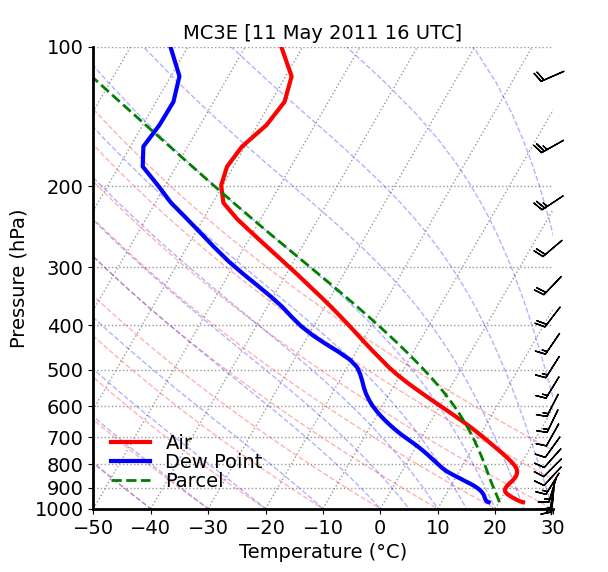

In [32]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[32])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ', parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::3], u_wind[::3], v_wind[::3], length=6, color='black', pivot='middle')#, flagscale=0.5)

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('MC3E [11 May 2011 16 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()